In [55]:
import math
import os
import shutil
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import tifffile
import torchvision.transforms.functional as TF
import torch
from pathlib import Path
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ColorJitter, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomAdjustSharpness, RandomResizedCrop, RandomAffine

from einops import rearrange

In [56]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [57]:
%matplotlib inline

In [58]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
%autoreload 2

In [60]:
import multiplex_imaging_pipeline.utils as utils

In [61]:
output_dir = '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1'
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [62]:
# pseudo_fps = sorted(utils.listfiles(os.path.join(output_dir, 'pseudo_fullres'), regex=r'.tif$'))
# sample_to_pseudo = {fp.split('/')[-1].replace('.tif', ''):fp for fp in pseudo_fps}

In [63]:
adata_fps = sorted(utils.listfiles(os.path.join(output_dir, 'spatial_features'), regex=r'.h5ad$'))
sample_to_adata = {fp.split('/')[-1].replace('.h5ad', ''):fp for fp in adata_fps}

In [64]:
region_fts_fps = sorted(utils.listfiles(os.path.join(output_dir, 'region_features'), regex=r'.txt$'))
sample_to_region_fts = {fp.split('/')[-1].replace('.txt', ''):fp for fp in region_fts_fps}

In [65]:
mask_fps = sorted(utils.listfiles(os.path.join(output_dir, 'region_features_masks'), regex=r'region.*.tif$'))
mask_fps = [fp for fp in mask_fps if 'region.tif' in fp]
sample_to_labeled = {fp.split('/')[-1].replace('_region.tif', ''):fp for fp in mask_fps}

In [66]:
thumbnail_fps = sorted(utils.listfiles(os.path.join(output_dir, 'region_features_masks'),
                                       regex=r'region_thumbnail_05.*.tif$'))
sample_to_labeled_thumbnail = {fp.split('/')[-1].replace('_region_thumbnail_05.tif', ''):tifffile.imread(fp)
                               for fp in thumbnail_fps}

In [67]:
clinical = pd.read_csv(
    '/diskmnt/Projects/Users/estorrs/imaging-analysis/data/brca_subtype/clinical/brca_subtypes.txt', sep='\t'
)
clinical

,Sample_ID,Case,Clinical_Subtype,Has_bulk,PAM50_bulk,Has_sn,PAM50_sn,Notes,FINAL_CALL,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,HT027B1_S1R1,HT027B1,ER+PR+,YES,NaN,YES,LumA,NaN,LumA,NaN,NaN,NaN,LumA,HT027B1_S1R1,HT029B1_S1PC,Basal
1,HT029B1_S1PC,HT029B1,TNBC,YES,Basal,YES,Basal,NaN,Basal,NaN,NaN,NaN,LumA,HT088B1_S1H1,HT035B1_S1PA,Basal
2,HT035B1_S1PA,HT035B1,TNBC,YES,Basal,YES,Basal,NaN,Basal,NaN,NaN,NaN,LumA,HT110B1_S1H4,HT036B1_S1PE,Basal
3,HT036B1_S1PE,HT036B1,TNBC,YES,Basal,YES,Basal,NaN,Basal,NaN,NaN,NaN,LumA,HT128B1_S1H3,HT036B1_S2PG,Basal
4,HT036B1_S2PG,HT036B1,TNBC,no,NaN,YES,Basal,NaN,Basal,NaN,NaN,NaN,LumA,HT128B1_S1H4,HT141B1_S1H1,Basal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,HT365B1_S1H1,HT365B1,ER+PR+HER2+,NaN,NaN,YES,Her2,NaN,Her2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,HT374B1_S1H3,HT374B1,ER+PR-HER2+,NaN,NaN,YES,Her2,NaN,Her2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,HT384B1_S1H1,HT384B1,TNBC,NaN,NaN,YES,NaN,sn tumor sample not subtyped (not in data freeze),NAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,HT284B1_M1,HT284B1,NaN,NaN,NaN,YES,NaN,normal sample therefore no PAM50,NAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
case_to_call = {c:x for c, x in zip(clinical['Case'], clinical['FINAL_CALL'])}

from alla

HT397B1 LumA
HT339B2 Basal
HT480B1 LumB
HT565B1 Basal

In [69]:
case_to_call.update({
    'HT397B1': 'LumA',
    'HT339B2': 'Basal',
    'HT480B1': 'LumB',
    'HT565B1': 'Basal',
})

In [70]:
pd.read_csv(next(iter(sample_to_region_fts.values())), sep='\t', index_col=0)

,region_r1,region_c1,region_r2,region_c2,region_area,region_perimeter,region_row,region_col,region_compactness,region_cell_fraction_default_annotation_CD8 T cell,...,expanded_marker_fraction_CK14,expanded_marker_fraction_CK17,expanded_marker_fraction_CK19,expanded_marker_fraction_ER,expanded_marker_fraction_GATA3,expanded_marker_fraction_HLA-DR,expanded_marker_fraction_PR,expanded_marker_fraction_Pan-Cytokeratin,expanded_marker_fraction_Podoplanin,expanded_marker_fraction_SMA
label,,,,,,,,,,,,,,,,,,,,,
1,12393,1635,20321,8363,145261,29305.071068,14656.459545,3607.557810,0.002126,0.000000,...,0.000742,0.000505,0.000278,0.000701,0.000646,0.000584,0.000350,0.000486,0.000585,0.000712
2,13107,4566,13340,4692,19471,654.433550,13221.489446,4628.472035,0.571304,0.000000,...,0.000009,0.000009,0.008284,0.000167,0.000405,0.000009,0.000009,0.070268,0.000282,0.000009
3,13113,8356,13124,9323,10637,1952.000000,13118.000000,8839.000000,0.035081,NaN,...,0.009743,0.004662,0.005114,0.015615,0.010070,0.007304,0.007596,0.007306,0.007438,0.009347
4,13833,9316,13844,10283,10637,1952.000000,13838.000000,9799.000000,0.035081,NaN,...,0.009740,0.003962,0.005279,0.013265,0.010073,0.007304,0.007469,0.007306,0.007466,0.009446
5,15630,5176,16261,5799,183966,3108.049999,15945.783536,5494.163280,0.239316,0.006211,...,0.006817,0.000061,0.147570,0.016393,0.000098,0.081942,0.036244,0.200717,0.035409,0.025373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,25087,13207,25256,13425,21537,951.286363,25165.226448,13318.306449,0.299070,0.000000,...,0.018457,0.000068,0.161217,0.009170,0.000010,0.068815,0.011404,0.201754,0.000476,0.019603
304,25147,13659,25343,13880,21002,835.955411,25246.970574,13754.373012,0.377663,0.000000,...,0.012991,0.000005,0.080930,0.009343,0.000103,0.076452,0.000717,0.093894,0.005152,0.018870
305,25170,13846,25283,14111,16435,863.144228,25226.698509,13975.475814,0.277213,0.000000,...,0.009155,0.000015,0.095551,0.006074,0.000643,0.186165,0.000044,0.116409,0.000805,0.060292


In [71]:
combined = None

cols = set()
for sample, fp in sample_to_region_fts.items():
    df = pd.read_csv(fp, sep='\t', index_col=0)
    cols.update(df.columns)
cols = sorted(cols)

for sample, fp in sample_to_region_fts.items():
    print(sample)
    df = pd.read_csv(fp, sep='\t', index_col=0)
    df.index = [f'{sample}_{x}' for x in df.index]
    
    if len(cols) > len(df.columns):
        missing = [c for c in cols if c not in df.columns]
        right = pd.DataFrame(data=np.full((df.shape[0], len(missing)), np.nan), columns=missing, index=df.index)
        df = pd.concat((df, right), axis=1)
    df = df[cols]
    
    if combined is None:
        combined = df
    else:
        combined = pd.concat((combined, df), axis=0)
combined
    

HT110B1_S1H4
HT171B1-S1H9A1-4_left_05122023
HT171B1-S1H9A1-4_right_05122023
HT171B1-S1H9A1-A4_left_05262023
HT171B1-S1H9A1-A4_right_05262023
HT206B1-S1H5_U1_07012023
HT206B1-S1H5_U2_07012023
HT206B1_H1
HT206B1_H1_06252022
HT206B1_S1H2L4_20221028
HT243B1-S1H4A4_04192023
HT243B1-S1H4A4_left_05122023
HT243B1-S1H4A4_left_05262023
HT243B1-S1H4A4_right_05122023
HT243B1-S1H4A4_right_05262023
HT243B1_S1H4
HT271B1-S1H6A5_04192023
HT271B1-S1H6A5_left_05122023
HT271B1-S1H6A5_left_05262023
HT271B1-S1H6A5_mid_05262023
HT271B1-S1H6A5_right_05122023
HT271B1-S1H6A5_right_05262023
HT297B1-S1H1_U1_07012023
HT297B1-S1H1_U2_07012023
HT305B1_S1H1
HT308B1-S1H5A4_04192023
HT308B1-S1H5A4_left_05122023
HT308B1-S1H5A4_left_05262023
HT308B1-S1H5A4_right_05122023
HT308B1-S1H5A4_right_05262023
HT323B1_H1A1
HT323B1_H1A4
HT323B1_H1_08042022
HT323B1_H3
HT339B1_H1A1
HT339B1_H2A1
HT339B2-H2_U1_07012023
HT339B2-H2_U2_07012023
HT365B1_S1H1_02132023
HT397B1_H2A2
HT397B1_H3A1
HT397B1_S1H1A3U22_04122023
HT397B1_S1H1A3U31_04

,boundary_area,boundary_c1,boundary_c2,boundary_cell_fraction_BCA1_annotation_BCA1 positive,boundary_cell_fraction_BCA1_annotation_Unlabeled,boundary_cell_fraction_CD163_annotation_CD163 positive,boundary_cell_fraction_CD163_annotation_Unlabeled,boundary_cell_fraction_CD68_annotation_CD68 positive,boundary_cell_fraction_CD68_annotation_Unlabeled,boundary_cell_fraction_CD8_annotation_CD8 positive,...,region_marker_intensity_TCF-1,region_marker_intensity_TFF1,region_marker_intensity_Vimentin,region_marker_intensity_a-Amylase,region_marker_intensity_beta-integrin,region_marker_intensity_cKit,region_perimeter,region_r1,region_r2,region_row
HT110B1_S1H4_1,4441980,1485,8513,NaN,1.0,0.500000,0.500000,0.0,1.0,0.500000,...,NaN,NaN,6.039818,NaN,NaN,9.949966,29305.071068,12393,20321,14656.459545
HT110B1_S1H4_2,156467,4416,4842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.816548,NaN,NaN,1.807919,654.433550,13107,13340,13221.489446
HT110B1_S1H4_3,363480,8206,9473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9.639372,NaN,NaN,13.973301,1952.000000,13113,13124,13118.000000
HT110B1_S1H4_4,363480,9166,10433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.264266,NaN,NaN,13.808969,1952.000000,13833,13844,13838.000000
HT110B1_S1H4_5,396822,5026,5949,NaN,1.0,0.024691,0.975309,0.0,1.0,0.024691,...,NaN,NaN,23.182713,NaN,NaN,8.160078,3108.049999,15630,16261,15945.783536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT565B1-S1H2_U2_07012023_114,172813,2344,2972,NaN,1.0,NaN,1.000000,NaN,1.0,0.090909,...,0.0,2.024776,50.633820,NaN,NaN,3.165969,1873.085353,11692,11764,11726.197325
HT565B1-S1H2_U2_07012023_115,1384939,3373,8028,NaN,1.0,NaN,1.000000,NaN,1.0,0.021368,...,0.0,1.686162,17.865203,NaN,NaN,4.567738,11274.184992,11693,11765,11728.497940
HT565B1-S1H2_U2_07012023_116,203658,1027,1394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,11.348120,9.098618,NaN,NaN,27.837403,1360.083261,12411,12932,12675.801476
HT565B1-S1H2_U2_07012023_117,281866,1349,2300,NaN,1.0,NaN,1.000000,NaN,1.0,0.750000,...,0.0,1.787634,2.519906,NaN,NaN,4.333188,1760.267027,12412,12484,12446.157737


In [72]:
combined['case_id'] = [re.sub('^(HT[0-9]+.[0-9]).*$', r'\1', x) for x in combined.index]
combined['sample_id'] = [re.sub('^(HT[0-9]+.[0-9].*)_[0-9]+$', r'\1', x) for x in combined.index]
set(combined['case_id'])

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_47517/3134745380.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined['case_id'] = [re.sub('^(HT[0-9]+.[0-9]).*$', r'\1', x) for x in combined.index]
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_47517/3134745380.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined['sample_id'] = [re.sub('^(HT[0-9]+.[0-9].*)_[0-9]+$', r'\1', x) for x in combined.index]


{'HT110B1',
 'HT171B1',
 'HT206B1',
 'HT243B1',
 'HT271B1',
 'HT297B1',
 'HT305B1',
 'HT308B1',
 'HT323B1',
 'HT339B1',
 'HT339B2',
 'HT365B1',
 'HT397B1',
 'HT480B1',
 'HT565B1'}

In [73]:
set(combined['sample_id'])

{'HT110B1_S1H4',
 'HT171B1-S1H9A1-4_left_05122023',
 'HT171B1-S1H9A1-4_right_05122023',
 'HT171B1-S1H9A1-A4_left_05262023',
 'HT171B1-S1H9A1-A4_right_05262023',
 'HT206B1-S1H5_U1_07012023',
 'HT206B1-S1H5_U2_07012023',
 'HT206B1_H1_06252022',
 'HT206B1_S1H2L4_20221028',
 'HT243B1-S1H4A4_04192023',
 'HT243B1-S1H4A4_left_05122023',
 'HT243B1-S1H4A4_left_05262023',
 'HT243B1-S1H4A4_right_05122023',
 'HT243B1-S1H4A4_right_05262023',
 'HT243B1_S1H4',
 'HT271B1-S1H6A5_04192023',
 'HT271B1-S1H6A5_left_05122023',
 'HT271B1-S1H6A5_left_05262023',
 'HT271B1-S1H6A5_mid_05262023',
 'HT271B1-S1H6A5_right_05122023',
 'HT271B1-S1H6A5_right_05262023',
 'HT297B1-S1H1_U1_07012023',
 'HT297B1-S1H1_U2_07012023',
 'HT305B1_S1H1',
 'HT308B1-S1H5A4_04192023',
 'HT308B1-S1H5A4_left_05122023',
 'HT308B1-S1H5A4_left_05262023',
 'HT308B1-S1H5A4_right_05122023',
 'HT308B1-S1H5A4_right_05262023',
 'HT323B1_H1A1',
 'HT323B1_H1A4',
 'HT323B1_H1_08042022',
 'HT323B1_H3',
 'HT339B1_H1A1',
 'HT339B1_H2A1',
 'HT339B2-H2

In [74]:
combined['subtype'] = [case_to_call[case] for case in combined['case_id']]

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_47517/1087774783.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined['subtype'] = [case_to_call[case] for case in combined['case_id']]


In [75]:
for case in set(combined['case_id']):
    if case not in case_to_call:
        print(case)

In [76]:
clf_probs = pd.read_csv(
    os.path.join(output_dir, 'classification_model_predictions', 'revised_labels.txt'),
    sep='\t', index_col=0
)

clf_probs

,artifact,dcis,idc,normal,sample_id,predicted_label,revised_label
region_id,,,,,,,
HT110B1_S1H4_108,0.000046,0.995500,0.002110,0.002345,HT110B1_S1H4,dcis,dcis
HT110B1_S1H4_140,0.000328,0.558524,0.004525,0.436623,HT110B1_S1H4,dcis,normal
HT110B1_S1H4_147,0.000330,0.809600,0.157995,0.032075,HT110B1_S1H4,dcis,idc
HT110B1_S1H4_155,0.000081,0.985948,0.010057,0.003914,HT110B1_S1H4,dcis,dcis
HT110B1_S1H4_204,0.000070,0.974752,0.001848,0.023329,HT110B1_S1H4,dcis,normal
...,...,...,...,...,...,...,...
HT565B1-S1H2_U2_07012023_99,0.000307,0.149647,0.837669,0.012377,HT565B1-S1H2_U2_07012023,idc,dcis
HT565B1-S1H2_U2_07012023_115,0.000030,0.000093,0.175036,0.824841,HT565B1-S1H2_U2_07012023,normal,artifact
HT565B1-S1H2_U2_07012023_18,0.000229,0.001117,0.131918,0.866736,HT565B1-S1H2_U2_07012023,normal,artifact


In [77]:
clf_probs = clf_probs[[c for c in clf_probs if c not in ['sample_id']]]
combined = pd.merge(combined, clf_probs, left_index=True, right_index=True, how='left')
combined

,boundary_area,boundary_c1,boundary_c2,boundary_cell_fraction_BCA1_annotation_BCA1 positive,boundary_cell_fraction_BCA1_annotation_Unlabeled,boundary_cell_fraction_CD163_annotation_CD163 positive,boundary_cell_fraction_CD163_annotation_Unlabeled,boundary_cell_fraction_CD68_annotation_CD68 positive,boundary_cell_fraction_CD68_annotation_Unlabeled,boundary_cell_fraction_CD8_annotation_CD8 positive,...,region_row,case_id,sample_id,subtype,artifact,dcis,idc,normal,predicted_label,revised_label
HT110B1_S1H4_1,4441980,1485,8513,NaN,1.0,0.500000,0.500000,0.0,1.0,0.500000,...,14656.459545,HT110B1,HT110B1_S1H4,NAT,0.000062,0.000183,0.054832,0.944923,normal,artifact
HT110B1_S1H4_2,156467,4416,4842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13221.489446,HT110B1,HT110B1_S1H4,NAT,0.000050,0.000716,0.790016,0.209218,idc,idc
HT110B1_S1H4_3,363480,8206,9473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13118.000000,HT110B1,HT110B1_S1H4,NAT,0.000028,0.000080,0.070192,0.929700,normal,artifact
HT110B1_S1H4_4,363480,9166,10433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13838.000000,HT110B1,HT110B1_S1H4,NAT,0.000027,0.000079,0.067560,0.932333,normal,artifact
HT110B1_S1H4_5,396822,5026,5949,NaN,1.0,0.024691,0.975309,0.0,1.0,0.024691,...,15945.783536,HT110B1,HT110B1_S1H4,NAT,0.000476,0.112462,0.786613,0.100449,idc,idc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT565B1-S1H2_U2_07012023_114,172813,2344,2972,NaN,1.0,NaN,1.000000,NaN,1.0,0.090909,...,11726.197325,HT565B1,HT565B1-S1H2_U2_07012023,Basal,0.000005,0.000026,0.996798,0.003171,idc,artifact
HT565B1-S1H2_U2_07012023_115,1384939,3373,8028,NaN,1.0,NaN,1.000000,NaN,1.0,0.021368,...,11728.497940,HT565B1,HT565B1-S1H2_U2_07012023,Basal,0.000030,0.000093,0.175036,0.824841,normal,artifact
HT565B1-S1H2_U2_07012023_116,203658,1027,1394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12675.801476,HT565B1,HT565B1-S1H2_U2_07012023,Basal,0.000018,0.000109,0.700784,0.299089,idc,artifact
HT565B1-S1H2_U2_07012023_117,281866,1349,2300,NaN,1.0,NaN,1.000000,NaN,1.0,0.750000,...,12446.157737,HT565B1,HT565B1-S1H2_U2_07012023,Basal,0.000004,0.000020,0.976133,0.023842,idc,artifact


In [78]:
def display_legend(cmap, n=50):
    fig, axs = plt.subplots(nrows=1, ncols=len(cmap))
    for i, (name, c) in enumerate(cmap.items()):
        ax = axs[i]
        rect = np.zeros((n, n, 3), dtype=np.float32)
        rect[:, :] = c
        ax.imshow(rect)
        ax.set_title(name)
        ax.set_xticks([])
        ax.set_yticks([])
        
def get_display_image(s, labeled, region_to_bbox, vmax=None,
                      color='area', cmap='viridis', df=None, order=None):
    if df is None:
        df = combined

    f = df[df['sample_id']==s]
    f.index = [x.split('_')[-1] for x in f.index]
    rbbox = None
    region_to_val = {reg:v
                     for reg, v in zip(f.index, f[color])}
    if region_to_val:
        rgba = utils.display_region(labeled, region_to_val, rbbox, cmap=cmap, vmax=vmax, cats=order)
    else:
        rgba = np.ones((labeled.shape[0], labeled.shape[1], 4))
    return rgba
        
def show_regions(feat, cmap=None, vmax=None, ncols=6, df=None, region_to_bbox=None):
    
    if df is None:
        df = combined

    samples = sorted(set(combined['sample_id']))
    nrows = (len(samples) // ncols) + 1
    
    vals = df[feat]
    try:
        float(vals[0])
        order = None
        is_numeric = True
    except:
        order = sorted(set(vals))
        is_numeric = False
    
    fig, axs = plt.subplots(nrows=nrows if nrows > 1 else 2, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
    stack = [(k, v) for k, v in sample_to_labeled_thumbnail.items() if k in samples]
    for i in range(nrows):
        for j in range(ncols):
            ax = axs[i, j]
            if len(stack):
                s, labeled = stack.pop(0)
                
                img = get_display_image(s, labeled, region_to_bbox,
                                        color=feat, df=df, cmap=cmap, order=order, vmax=vmax)
                ax.imshow(img)
                ax.set_title(s)
            ax.axis('equal')
            ax.axis('off') 
            
    plt.show()
    
    if is_numeric:
        pass
    else:
        cmap = {k:v 
                for k, v in zip(sorted(set(vals)), sns.color_palette('tab10' if cmap is None else cmap))}
        display_legend(cmap)
        plt.show()

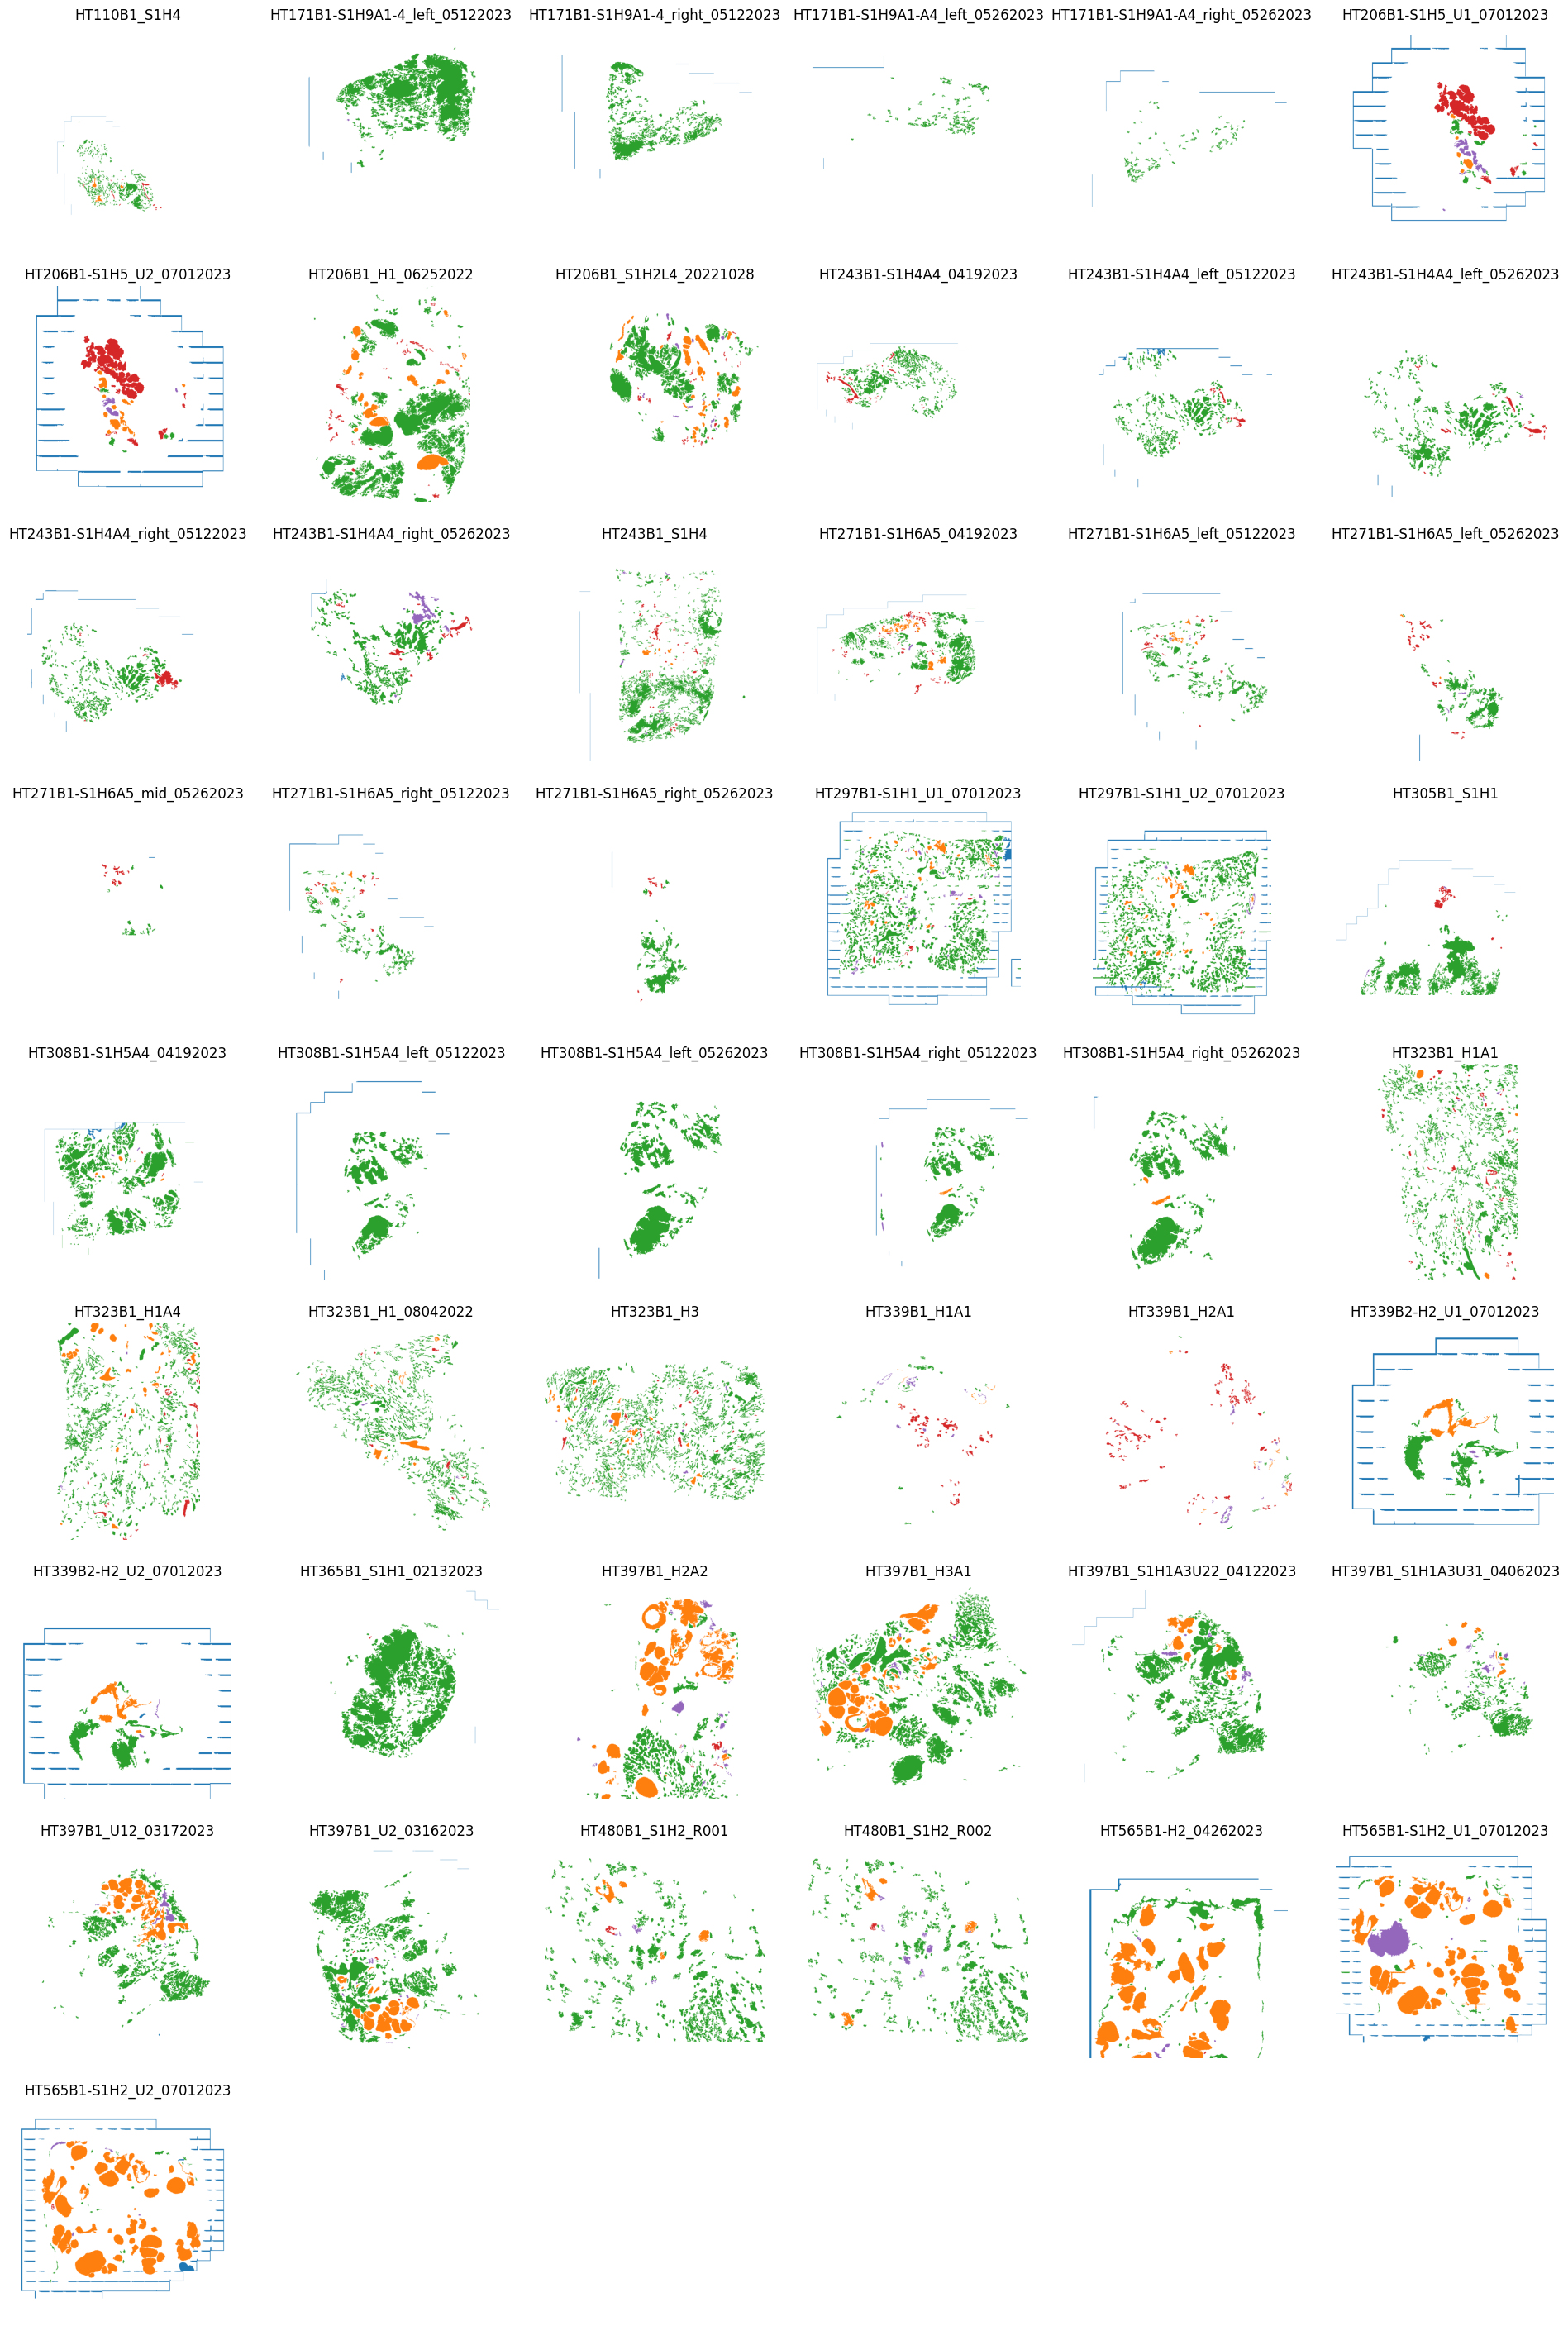

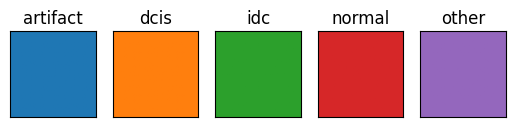

In [79]:
show_regions('revised_label')

In [80]:
# throw out artifact and unsure
combined = combined[[True if x in ['dcis', 'idc', 'normal'] else False
                    for x in combined['revised_label']]]
combined

,boundary_area,boundary_c1,boundary_c2,boundary_cell_fraction_BCA1_annotation_BCA1 positive,boundary_cell_fraction_BCA1_annotation_Unlabeled,boundary_cell_fraction_CD163_annotation_CD163 positive,boundary_cell_fraction_CD163_annotation_Unlabeled,boundary_cell_fraction_CD68_annotation_CD68 positive,boundary_cell_fraction_CD68_annotation_Unlabeled,boundary_cell_fraction_CD8_annotation_CD8 positive,...,region_row,case_id,sample_id,subtype,artifact,dcis,idc,normal,predicted_label,revised_label
HT110B1_S1H4_2,156467,4416,4842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13221.489446,HT110B1,HT110B1_S1H4,NAT,0.000050,0.000716,0.790016,0.209218,idc,idc
HT110B1_S1H4_5,396822,5026,5949,NaN,1.0,0.024691,0.975309,0.0,1.0,0.024691,...,15945.783536,HT110B1,HT110B1_S1H4,NAT,0.000476,0.112462,0.786613,0.100449,idc,idc
HT110B1_S1H4_6,92480,6347,6732,NaN,1.0,0.000000,1.000000,0.0,1.0,0.000000,...,15827.959297,HT110B1,HT110B1_S1H4,NAT,0.000006,0.000046,0.993704,0.006243,idc,idc
HT110B1_S1H4_7,90522,6193,6668,NaN,1.0,0.097561,0.902439,0.0,1.0,0.121951,...,15956.656231,HT110B1,HT110B1_S1H4,NAT,0.000043,0.001921,0.994025,0.004012,idc,idc
HT110B1_S1H4_8,148250,5845,6273,NaN,1.0,0.048077,0.951923,0.0,1.0,0.019231,...,16022.796640,HT110B1,HT110B1_S1H4,NAT,0.000033,0.000758,0.986409,0.012799,idc,idc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT565B1-S1H2_U2_07012023_101,300474,2522,2983,NaN,1.0,NaN,1.000000,NaN,1.0,0.000000,...,10591.767721,HT565B1,HT565B1-S1H2_U2_07012023,Basal,0.000118,0.001914,0.804777,0.193191,idc,idc
HT565B1-S1H2_U2_07012023_103,380337,6258,7197,NaN,1.0,NaN,1.000000,NaN,1.0,0.047059,...,10798.923368,HT565B1,HT565B1-S1H2_U2_07012023,Basal,0.000355,0.446863,0.548513,0.004269,idc,dcis
HT565B1-S1H2_U2_07012023_104,122924,5796,6352,NaN,1.0,NaN,1.000000,NaN,1.0,0.064516,...,10926.140112,HT565B1,HT565B1-S1H2_U2_07012023,Basal,0.000329,0.786764,0.200838,0.012069,dcis,dcis
HT565B1-S1H2_U2_07012023_110,141560,2308,2792,NaN,1.0,NaN,1.000000,NaN,1.0,0.000000,...,11130.826254,HT565B1,HT565B1-S1H2_U2_07012023,Basal,0.000090,0.001997,0.940999,0.056914,idc,idc


In [81]:
combined['macro_label'] = ['tumor' if x in ['idc', 'dcis'] else 'normal'
                          for x in combined['revised_label']]

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_47517/1237148907.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined['macro_label'] = ['tumor' if x in ['idc', 'dcis'] else 'normal'
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_47517/1237148907.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined['macro_label'] = ['tumor' if x in ['idc', 'dcis'] else 'normal'


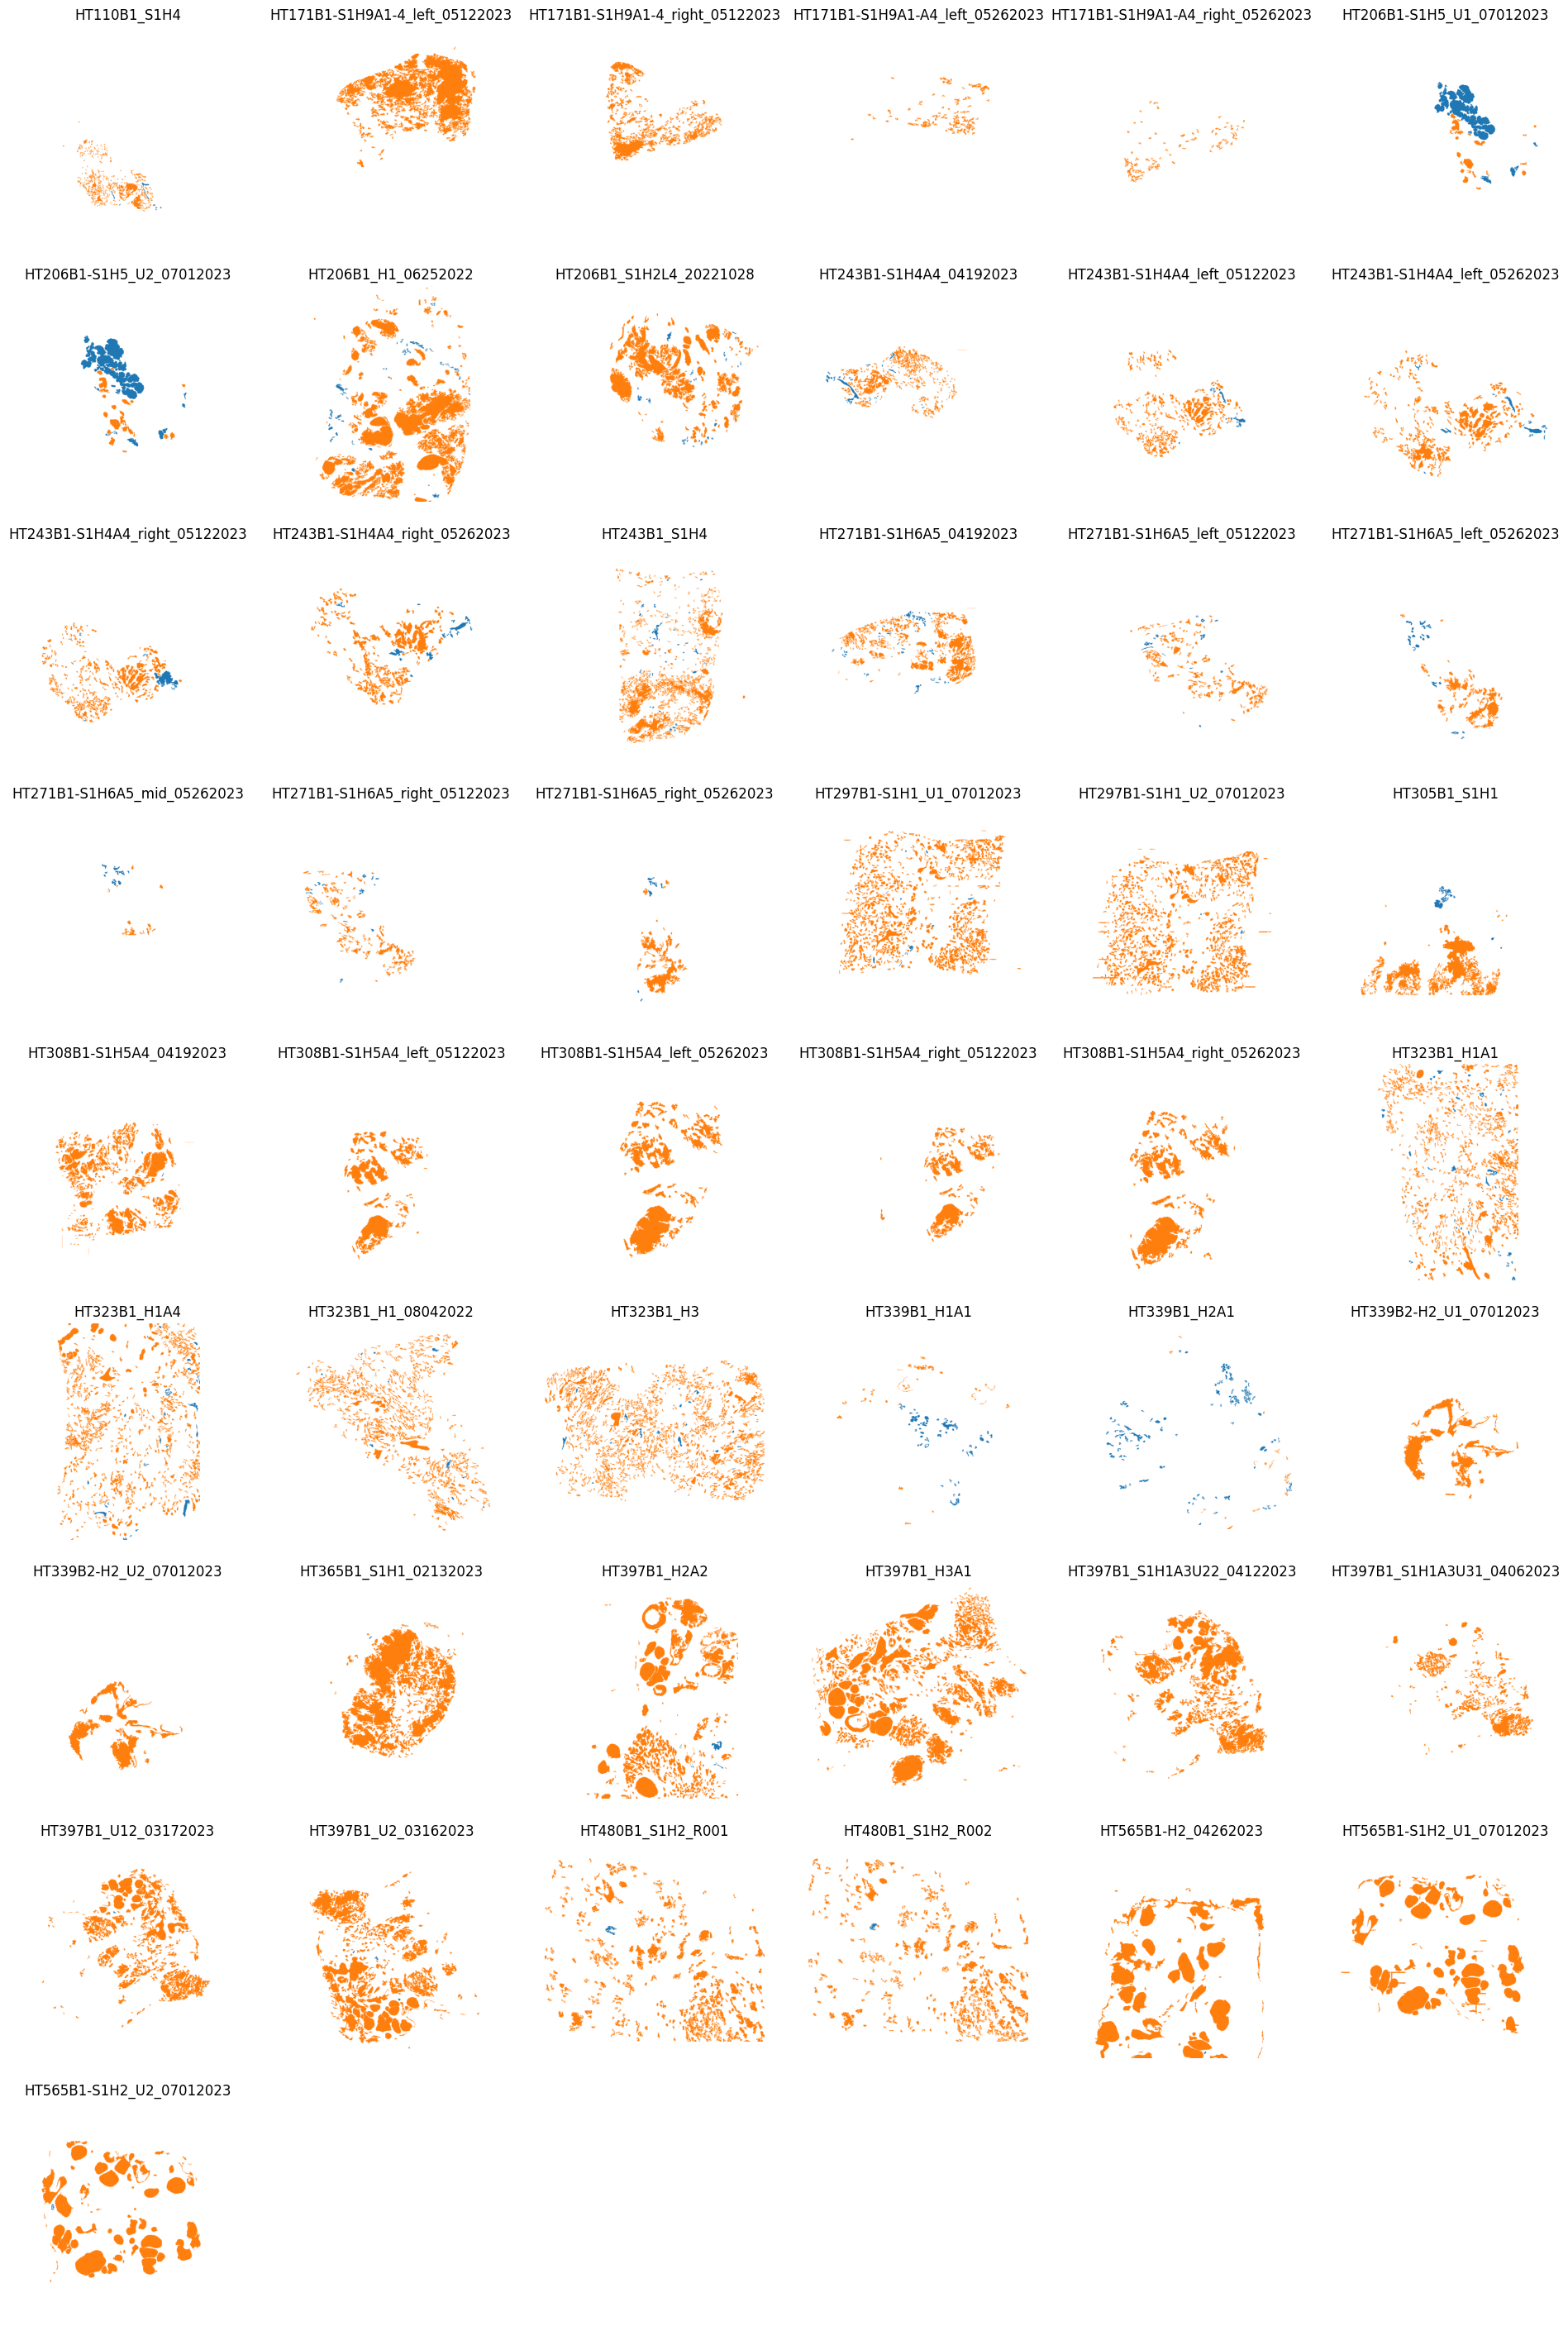

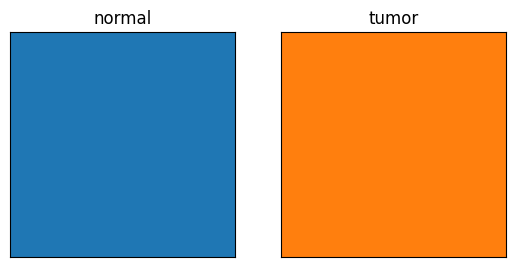

In [82]:
show_regions('macro_label')

In [83]:
list(combined.columns)

['boundary_area',
 'boundary_c1',
 'boundary_c2',
 'boundary_cell_fraction_BCA1_annotation_BCA1 positive',
 'boundary_cell_fraction_BCA1_annotation_Unlabeled',
 'boundary_cell_fraction_CD163_annotation_CD163 positive',
 'boundary_cell_fraction_CD163_annotation_Unlabeled',
 'boundary_cell_fraction_CD68_annotation_CD68 positive',
 'boundary_cell_fraction_CD68_annotation_Unlabeled',
 'boundary_cell_fraction_CD8_annotation_CD8 positive',
 'boundary_cell_fraction_CD8_annotation_Unlabeled',
 'boundary_cell_fraction_CK14_annotation_Unlabeled',
 'boundary_cell_fraction_CK14_annotation_epithelial - CK14 positive',
 'boundary_cell_fraction_CK19_annotation_Unlabeled',
 'boundary_cell_fraction_CK19_annotation_epithelial - CK19 positive',
 'boundary_cell_fraction_CTLA4_annotation_CTLA4 positive',
 'boundary_cell_fraction_CTLA4_annotation_Unlabeled',
 'boundary_cell_fraction_ER_annotation_Unlabeled',
 'boundary_cell_fraction_ER_annotation_epithelial - ER positive',
 'boundary_cell_fraction_GATA3_ann

In [84]:
samples = sorted(set(combined['sample_id']))
len(samples), samples

(49,
 ['HT110B1_S1H4',
  'HT171B1-S1H9A1-4_left_05122023',
  'HT171B1-S1H9A1-4_right_05122023',
  'HT171B1-S1H9A1-A4_left_05262023',
  'HT171B1-S1H9A1-A4_right_05262023',
  'HT206B1-S1H5_U1_07012023',
  'HT206B1-S1H5_U2_07012023',
  'HT206B1_H1_06252022',
  'HT206B1_S1H2L4_20221028',
  'HT243B1-S1H4A4_04192023',
  'HT243B1-S1H4A4_left_05122023',
  'HT243B1-S1H4A4_left_05262023',
  'HT243B1-S1H4A4_right_05122023',
  'HT243B1-S1H4A4_right_05262023',
  'HT243B1_S1H4',
  'HT271B1-S1H6A5_04192023',
  'HT271B1-S1H6A5_left_05122023',
  'HT271B1-S1H6A5_left_05262023',
  'HT271B1-S1H6A5_mid_05262023',
  'HT271B1-S1H6A5_right_05122023',
  'HT271B1-S1H6A5_right_05262023',
  'HT297B1-S1H1_U1_07012023',
  'HT297B1-S1H1_U2_07012023',
  'HT305B1_S1H1',
  'HT308B1-S1H5A4_04192023',
  'HT308B1-S1H5A4_left_05122023',
  'HT308B1-S1H5A4_left_05262023',
  'HT308B1-S1H5A4_right_05122023',
  'HT308B1-S1H5A4_right_05262023',
  'HT323B1_H1A1',
  'HT323B1_H1A4',
  'HT323B1_H1_08042022',
  'HT323B1_H3',
  'HT339

In [85]:
case_to_subtype = {cid:x for cid, x in zip(combined['case_id'], combined['subtype'])}
case_to_subtype

{'HT110B1': 'NAT',
 'HT171B1': 'Basal',
 'HT206B1': 'Basal',
 'HT243B1': 'LumA',
 'HT271B1': 'Basal',
 'HT297B1': 'LumA',
 'HT305B1': 'LumB',
 'HT308B1': 'LumB',
 'HT323B1': 'LumB',
 'HT339B1': 'Basal',
 'HT339B2': 'Basal',
 'HT365B1': 'Her2',
 'HT397B1': 'LumA',
 'HT480B1': 'LumB',
 'HT565B1': 'Basal'}

In [86]:
combined = combined[combined['subtype']!='NAT']
combined = combined[combined['subtype']!='Her2']

In [133]:
def plot_frac_positive_cells_overall(combined, markers, figsize=(20, 4), groupby=None, key='region'):
    subtype_order = ['Basal', 'LumA', 'LumB']
    label_order = ['normal', 'tumor']
    label_col = 'macro_label'
    
    marker_to_df = {}
    for marker in markers:
        if marker in ['GATA3', 'cKit', 'CK14', 'CK19', 'ER', 'PR', 'Her2']:
            ct_col = f'{key}_cell_fraction_{marker}_annotation_epithelial - {marker} positive'
        else:
            ct_col = f'{key}_cell_fraction_{marker}_annotation_{marker} positive'
        frac_col = f'{key}_marker_fraction_{marker}'
        pool = sorted({sid for sid, x in zip(combined['sample_id'], combined[frac_col])
               if not pd.isnull(x)})

        f = combined[['case_id', 'sample_id', 'subtype', label_col, ct_col, frac_col]]
        
        if groupby is not None:
            f = f[[c for c in f.columns if c in [groupby, label_col, 'subtype', ct_col, frac_col]]]
            f = f.groupby([groupby, label_col, 'subtype']).mean()
            for c in [label_col, 'subtype']:
                f[c] = f.index.get_level_values(c)
            f.index = f.index.get_level_values(groupby)
        
            print(len({x for x, val in zip(f.index, f[ct_col]) if not pd.isnull(val)}))
            print({re.split(r'[_-]', x)[0] for x, val in zip(f.index, f[ct_col]) if not pd.isnull(val)})

        marker_to_df[marker] = f
        
        
    fig, axs = plt.subplots(nrows=1, ncols=len(marker_to_df), figsize=figsize, sharey=True)
    for c, (marker, df) in enumerate(marker_to_df.items()):
        if marker in ['GATA3', 'cKit', 'CK14', 'CK19', 'ER', 'PR', 'Her2']:
            ct_col = f'{key}_cell_fraction_{marker}_annotation_epithelial - {marker} positive'
        else:
            ct_col = f'{key}_cell_fraction_{marker}_annotation_{marker} positive'
        frac_col = f'{key}_marker_fraction_{marker}'
        
        df.index = list(range(df.shape[0]))
        ax = axs[c]
        kwargs = {
#             'boxprops':{'facecolor':'none'},
            
            'boxprops': {'alpha': 0.4},
        }
        sns.boxplot(data=df, x='subtype', y=ct_col, hue=label_col, ax=ax, showfliers=False,
                   order=subtype_order, hue_order=label_order, **kwargs)
        
        sns.stripplot(data=df, x='subtype', y=ct_col, hue=label_col, ax=ax,
                   order=subtype_order, hue_order=label_order, dodge=True)
        
        ax.set_title(marker)

        ax.set_xlabel('')
        if c!=len(markers) - 1:
            ax.get_legend().remove()

        if c==0:
            ax.set_ylabel(f'Positive cell fraction')
        else:
            ax.set_ylabel('')      

45
{'HT243B1', 'HT305B1', 'HT171B1', 'HT206B1', 'HT308B1', 'HT397B1', 'HT323B1', 'HT297B1', 'HT339B1', 'HT480B1', 'HT339B2', 'HT565B1', 'HT271B1'}
42
{'HT243B1', 'HT305B1', 'HT171B1', 'HT206B1', 'HT308B1', 'HT397B1', 'HT323B1', 'HT297B1', 'HT339B1', 'HT480B1', 'HT339B2', 'HT565B1', 'HT271B1'}
44
{'HT243B1', 'HT305B1', 'HT171B1', 'HT206B1', 'HT308B1', 'HT397B1', 'HT323B1', 'HT297B1', 'HT339B1', 'HT480B1', 'HT339B2', 'HT565B1', 'HT271B1'}
27
{'HT243B1', 'HT305B1', 'HT171B1', 'HT308B1', 'HT397B1', 'HT565B1', 'HT271B1'}
39
{'HT243B1', 'HT305B1', 'HT171B1', 'HT206B1', 'HT308B1', 'HT397B1', 'HT323B1', 'HT297B1', 'HT480B1', 'HT339B2', 'HT565B1', 'HT271B1'}
39
{'HT243B1', 'HT305B1', 'HT171B1', 'HT206B1', 'HT308B1', 'HT397B1', 'HT323B1', 'HT297B1', 'HT480B1', 'HT339B2', 'HT565B1', 'HT271B1'}
33
{'HT243B1', 'HT171B1', 'HT206B1', 'HT308B1', 'HT397B1', 'HT297B1', 'HT339B2', 'HT565B1', 'HT271B1'}


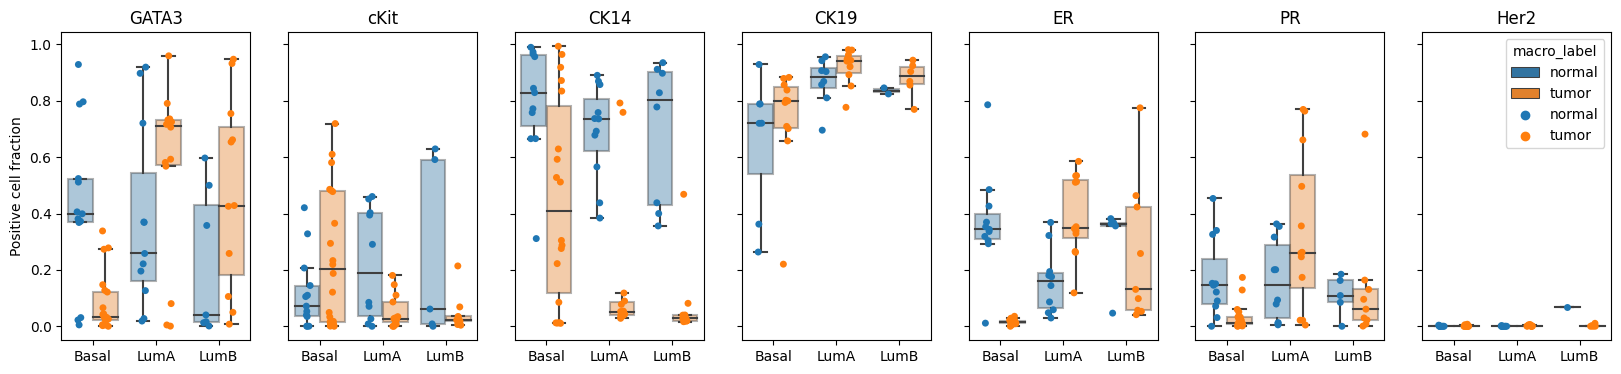

In [137]:
markers = [
    'GATA3',
    'cKit',
    'CK14',
    'CK19',
    'ER',
    'PR',
    'Her2',
]
plot_frac_positive_cells_overall(combined, markers, groupby='sample_id')
plt.savefig(
    '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/figures/epithelial_boxplots.pdf')

In [116]:
def get_significance(combined, markers, groupby=None, key='region'):
#     subtype_order = ['Basal', 'LumA', 'LumB']
#     label_order = ['normal', 'tumor']
    label_col = 'macro_label'

    marker_to_df = {}
    for marker in markers:
        if marker in ['GATA3', 'cKit', 'CK14', 'CK19', 'ER', 'PR', 'Her2']:
            ct_col = f'{key}_cell_fraction_{marker}_annotation_epithelial - {marker} positive'
        else:
            ct_col = f'{key}_cell_fraction_{marker}_annotation_{marker} positive'
        frac_col = f'{key}_marker_fraction_{marker}'
        pool = sorted({sid for sid, x in zip(combined['sample_id'], combined[frac_col])
               if not pd.isnull(x)})

        f = combined[['case_id', 'sample_id', 'subtype', label_col, ct_col, frac_col]]
        
        if groupby is not None:
            f = f[[c for c in f.columns if c in [groupby, label_col, 'subtype', ct_col, frac_col]]]
            f = f.groupby([groupby, label_col, 'subtype']).mean()
            for c in [label_col, 'subtype']:
                f[c] = f.index.get_level_values(c)
            f.index = f.index.get_level_values(groupby)

        marker_to_df[marker] = f
        
    for marker, df in marker_to_df.items():
        if marker in ['GATA3', 'cKit', 'CK14', 'CK19', 'ER', 'PR', 'Her2']:
            ct_col = f'{key}_cell_fraction_{marker}_annotation_epithelial - {marker} positive'
        else:
            ct_col = f'{key}_cell_fraction_{marker}_annotation_{marker} positive'
        frac_col = f'{key}_marker_fraction_{marker}'

        xs = [x for label, subtype, x in zip(df[label_col], df['subtype'], df[ct_col])
             if label=='tumor' and subtype in ['Basal'] and not pd.isnull(x)]
        ys = [x for label, subtype, x in zip(df[label_col], df['subtype'], df[ct_col])
             if label=='tumor' and subtype in ['LumA', 'LumB'] and not pd.isnull(x)]
        

        print(marker, ttest_ind(xs, ys)[1])

In [117]:
import statsmodels
from statsmodels.stats.weightstats import ttest_ind

In [118]:
markers = [
    'GATA3',
    'cKit',
]
get_significance(combined, markers, groupby='sample_id', key='region')

GATA3 4.103068548498413e-07
cKit 0.0006900422855425307


In [120]:
np.unique(combined['macro_label'], return_counts=True)

(array(['normal', 'tumor'], dtype=object), array([  649, 10753]))

In [152]:
z_df.index.names

FrozenList(['sample_id', 'macro_label'])

In [170]:
df = combined[['sample_id', 'macro_label', 'region_marker_intensity_Ki67', 'subtype']]
stds = df.groupby(['sample_id', 'macro_label', 'subtype']).std()
means = df.groupby(['sample_id', 'macro_label', 'subtype']).mean()
z_df = means / stds
for c in z_df.index.names:
    z_df[c] = z_df.index.get_level_values(c)
z_df.index = list(range(z_df.shape[0]))

# there is one really wild outlier
z_df = z_df[z_df['region_marker_intensity_Ki67']<10]
z_df


,region_marker_intensity_Ki67,sample_id,macro_label,subtype
0,2.085549,HT171B1-S1H9A1-4_left_05122023,tumor,Basal
1,1.959227,HT171B1-S1H9A1-4_right_05122023,tumor,Basal
2,2.284572,HT171B1-S1H9A1-A4_left_05262023,tumor,Basal
3,1.712319,HT171B1-S1H9A1-A4_right_05262023,tumor,Basal
4,1.616791,HT206B1-S1H5_U1_07012023,normal,Basal
...,...,...,...,...
74,0.364175,HT480B1_S1H2_R002,tumor,LumB
76,0.733418,HT565B1-H2_04262023,tumor,Basal
77,1.635555,HT565B1-S1H2_U1_07012023,tumor,Basal
78,5.112896,HT565B1-S1H2_U2_07012023,normal,Basal


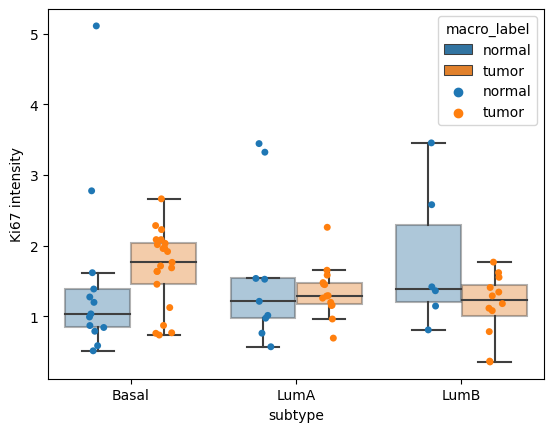

In [162]:
subtype_order = ['Basal', 'LumA', 'LumB']
label_order = ['normal', 'tumor']
sns.boxplot(data=z_df, x='subtype', y='region_marker_intensity_Ki67', hue='macro_label', showfliers=False,
           order=subtype_order, hue_order=label_order, boxprops={'alpha': 0.4})

sns.stripplot(data=z_df, x='subtype', y='region_marker_intensity_Ki67', hue='macro_label',
           order=subtype_order, hue_order=label_order, dodge=True)

plt.ylabel('Ki67 intensity')
plt.savefig(
    '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/figures/ki67_boxplot.pdf')

In [173]:
from scipy.stats import mannwhitneyu

In [175]:
for subtype in subtype_order:
    f = z_df[z_df['subtype']==subtype]
    tups = [(x, y) for label, x in zip(f['macro_label'], f['region_marker_intensity_Ki67'])
             if label=='normal' and not pd.isnull(x)]
    xs, ys = zip(*[(x, y) for label, x in zip(f['macro_label'], f['region_marker_intensity_Ki67'])
         if label=='normal' and not pd.isnull(x)]
    ys = [x for label, x in zip(f['macro_label'], f['region_marker_intensity_Ki67'])
         if label=='tumor' and not pd.isnull(x)]
    
    print(subtype, mannwhitneyu(xs, ys).pvalue)

Basal 0.04719391926101514
LumA 0.8748624733342836
LumB 0.24962292609351436


In [138]:
combined

,boundary_area,boundary_c1,boundary_c2,boundary_cell_fraction_BCA1_annotation_BCA1 positive,boundary_cell_fraction_BCA1_annotation_Unlabeled,boundary_cell_fraction_CD163_annotation_CD163 positive,boundary_cell_fraction_CD163_annotation_Unlabeled,boundary_cell_fraction_CD68_annotation_CD68 positive,boundary_cell_fraction_CD68_annotation_Unlabeled,boundary_cell_fraction_CD8_annotation_CD8 positive,...,case_id,sample_id,subtype,artifact,dcis,idc,normal,predicted_label,revised_label,macro_label
HT171B1-S1H9A1-4_left_05122023_1,121358,11618,12054,0.000000,1.000000,NaN,1.0,NaN,1.0,0.000000,...,HT171B1,HT171B1-S1H9A1-4_left_05122023,Basal,4.972345e-05,6.162786e-04,0.937824,0.061510,idc,idc,tumor
HT171B1-S1H9A1-4_left_05122023_2,3423527,9331,13184,0.014136,0.985864,NaN,1.0,NaN,1.0,0.022179,...,HT171B1,HT171B1-S1H9A1-4_left_05122023,Basal,4.350274e-04,3.816857e-02,0.942678,0.018718,idc,idc,tumor
HT171B1-S1H9A1-4_left_05122023_3,2534349,6223,9996,0.015939,0.984061,NaN,1.0,NaN,1.0,0.025183,...,HT171B1,HT171B1-S1H9A1-4_left_05122023,Basal,5.451885e-05,9.966497e-01,0.002487,0.000808,dcis,idc,tumor
HT171B1-S1H9A1-4_left_05122023_4,56267,11149,11516,0.000000,1.000000,NaN,1.0,NaN,1.0,0.000000,...,HT171B1,HT171B1-S1H9A1-4_left_05122023,Basal,2.100396e-06,7.900554e-06,0.998964,0.001026,idc,idc,tumor
HT171B1-S1H9A1-4_left_05122023_5,23004,10449,10769,0.000000,1.000000,NaN,1.0,NaN,1.0,0.050000,...,HT171B1,HT171B1-S1H9A1-4_left_05122023,Basal,1.167267e-07,2.537323e-07,0.999955,0.000045,idc,idc,tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT565B1-S1H2_U2_07012023_101,300474,2522,2983,NaN,1.000000,NaN,1.0,NaN,1.0,0.000000,...,HT565B1,HT565B1-S1H2_U2_07012023,Basal,1.180736e-04,1.913533e-03,0.804777,0.193191,idc,idc,tumor
HT565B1-S1H2_U2_07012023_103,380337,6258,7197,NaN,1.000000,NaN,1.0,NaN,1.0,0.047059,...,HT565B1,HT565B1-S1H2_U2_07012023,Basal,3.549815e-04,4.468630e-01,0.548513,0.004269,idc,dcis,tumor
HT565B1-S1H2_U2_07012023_104,122924,5796,6352,NaN,1.000000,NaN,1.0,NaN,1.0,0.064516,...,HT565B1,HT565B1-S1H2_U2_07012023,Basal,3.286201e-04,7.867643e-01,0.200838,0.012069,dcis,dcis,tumor
HT565B1-S1H2_U2_07012023_110,141560,2308,2792,NaN,1.000000,NaN,1.0,NaN,1.0,0.000000,...,HT565B1,HT565B1-S1H2_U2_07012023,Basal,9.002139e-05,1.996695e-03,0.940999,0.056914,idc,idc,tumor


In [179]:
list(combined.columns)

['boundary_area',
 'boundary_c1',
 'boundary_c2',
 'boundary_cell_fraction_BCA1_annotation_BCA1 positive',
 'boundary_cell_fraction_BCA1_annotation_Unlabeled',
 'boundary_cell_fraction_CD163_annotation_CD163 positive',
 'boundary_cell_fraction_CD163_annotation_Unlabeled',
 'boundary_cell_fraction_CD68_annotation_CD68 positive',
 'boundary_cell_fraction_CD68_annotation_Unlabeled',
 'boundary_cell_fraction_CD8_annotation_CD8 positive',
 'boundary_cell_fraction_CD8_annotation_Unlabeled',
 'boundary_cell_fraction_CK14_annotation_Unlabeled',
 'boundary_cell_fraction_CK14_annotation_epithelial - CK14 positive',
 'boundary_cell_fraction_CK19_annotation_Unlabeled',
 'boundary_cell_fraction_CK19_annotation_epithelial - CK19 positive',
 'boundary_cell_fraction_CTLA4_annotation_CTLA4 positive',
 'boundary_cell_fraction_CTLA4_annotation_Unlabeled',
 'boundary_cell_fraction_ER_annotation_Unlabeled',
 'boundary_cell_fraction_ER_annotation_epithelial - ER positive',
 'boundary_cell_fraction_GATA3_ann

In [181]:
pool = [c.replace('region_marker_intensity_', '') for c in combined.columns if 'region_marker_intensity' in c]
for x in pool: print(x)

BCA1
Bap1
CD11b
CD11c
CD138
CD163
CD20
CD31
CD36
CD39
CD3e
CD4
CD44
CD45
CD45RA
CD45RO
CD68
CD8
CK14
CK17
CK19
CK5
COX2
COX6c
CTLA4
DAPI
E-cadherin
ER
FGFR3
FOXP3
GATA3
GLUT1
GP2
Granzyme-B
HIF1A
HLA-DR
Hep-Par-1
Her2
Histone H3 Phospho (Ser28)
Histone-H3-Pho
Ki67
Lyve-1
MGP
MLPH
MMP9
Maspin
P16
P21
P63
PD1
PDL1
PLAT/tPA
PR
Pan-Cytokeratin
Podoplanin
SLC39A6
SMA
TCF-1
TFF1
Vimentin
a-Amylase
beta-integrin
cKit


In [183]:
set(combined['case_id'])

{'HT171B1',
 'HT206B1',
 'HT243B1',
 'HT271B1',
 'HT297B1',
 'HT305B1',
 'HT308B1',
 'HT323B1',
 'HT339B1',
 'HT339B2',
 'HT397B1',
 'HT480B1',
 'HT565B1'}

In [184]:
len(set(combined['sample_id']))

47